In [97]:
"Importing the necessary libraries"
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split
import gc; gc.enable() # memory is tight

import tensorflow as tf
from keras import layers, models
from keras import backend as K
from keras import optimizers
from tensorflow.keras.optimizers import Adam
pd.set_option('display.max_colwidth',None)

In [79]:
"Reading the files into a dataframe"
train_image_dir_l = r'C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/'

train_image_dir = r'C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/'

images =  [(train_image_dir+f) for f in listdir(train_image_dir) if isfile(join(train_image_dir, f))]
masks = [(train_image_dir_l+f) for f in listdir(train_image_dir_l) if isfile(join(train_image_dir_l, f))]

df = pd.DataFrame(np.column_stack([images, masks]), columns=['images', 'masks'])

In [80]:
df

,images,masks
0,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/000000.txt,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/000000.png
1,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/000001.txt,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/000001.png
2,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/000002.txt,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/000002.png
3,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/000003.txt,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/000003.png
4,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/000004.txt,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/000004.png
...,...,...
96,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/000096.txt,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/000096.png
97,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/000097.txt,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/000097.png
98,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/000098.txt,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/000098.png
99,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_label_2/training/label_2/000099.txt,C:/Users/rabhishek1/Downloads/KittiDataset_sample-20221010T135836Z-001/KittiDataset_sample/data_object_image_2/training/image_2/000099.png


In [104]:
"Sorting the list of paths so that the mask and image are from the same set"
df1 = df.sort_values(by='images')['images'].reset_index()
df2 = df.sort_values(by='masks')['masks'].reset_index()
df['images'] = df1['images']
df['masks'] = df2['masks']
del df1, df2

In [170]:
def create_mask(mask_dir, img_shape):
"Mask generator function from the image and given co-ordinateds"
    mask = np.zeros(shape=(img_shape[0], img_shape[1], 1))

    with open(mask_dir) as f:
        content = f.readlines()
    content = [x.split() for x in content] 
    for item in content:
        if item[0]=='Car' or item[0]=='Truck' or item[0]=='Van' or item[0]=='Pedestrian':
            ul_col, ul_row = int(float(item[4])), int(float(item[5]))
            lr_col, lr_row = int(float(item[6])), int(float(item[7]))
            
            mask[ul_row:lr_row, ul_col:lr_col, 0] = 1 
    return mask

In [107]:
"performing the train test split and declearing the necessary hyper parameters"
df_train, df_val = train_test_split(df, test_size=0.25, shuffle=False)
BATCH_SIZE = 64
EDGE_CROP = 16
NB_EPOCHS = 30
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [171]:
def create_images_generator(df_in, batch_size, resized_shape):
    "function for resizing the imgaes and stacking it for model input"
    batch_image = []
    batch_mask = []
    df_in_list = (df_in).values.tolist()
    np.random.shuffle(df_in_list)
    # return df_in_list    
    
    while True:
        for mask_path, image_path in df_in_list:

            image_r = cv2.imread(image_path)

            mask_r = create_mask(mask_path, image_r.shape)
            
            image_r = cv2.resize(image_r,(resized_shape[1], resized_shape[0]))
            mask_r = cv2.resize(mask_r,(resized_shape[1], resized_shape[0]))
            
            
            
            batch_image.append(image_r)
            batch_mask.append(mask_r)
            
            if len(batch_mask)>=batch_size:
                print("one")
                yield np.float32(np.stack((batch_image), 0)/255.0), np.stack(np.float32(np.expand_dims(batch_mask, -1)), 0)
                batch_image, batch_mask = [], []
            
#     print(batch_image)
#     return batch_image,batch_mask

Car
Van
Car
Car
Car
Pedestrian
Car
Truck
Car
Car
Car
Car
Truck
Car
Car
Car
Car
Van
Car
Car
Car
Car
Truck
Car
Van
Car
Car
Car
Car
Car
Car
Pedestrian
Car
Car
Van
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Truck
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Van
Pedestrian
Car
Car
Car
Pedestrian
Car
Car
Car
Car
Car
Van
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Pedestrian
Pedestrian
Pedestrian
Pedestrian
Pedestrian
Pedestrian
Car
Pedestrian
Pedestrian
Car
Pedestrian
Car
Pedestrian
Car
Car
Pedestrian
Car
Car
Car
Car
Car
Car
Pedestrian
Car
Car
Van
Car
Car
Van
Car
Van
Van
Car
Car
Car
Truck
Car
Car
Car
Car
Car
Van
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Van
Car
Car
Car
Car
Car
Car
Pedestrian
Pedestrian
Pedestrian
Pedestrian
Pedestrian
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Car
Van
Car
Car
Pedestrian
Van
Car
Car
Car
Car
Car
Van
Car
Car
Car
Car
Pedestrian
Pedestrian
Pedestrian
Pedestrian
Van
Car
Car
Car
Car
Car
Pedestrian
Truck

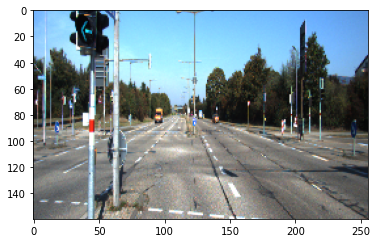

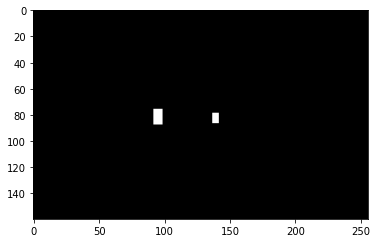

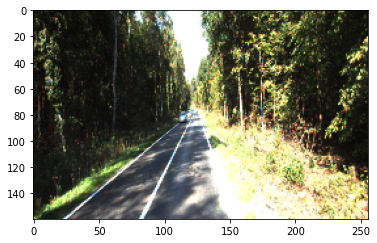

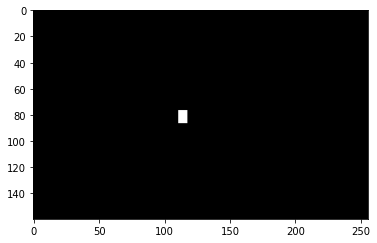

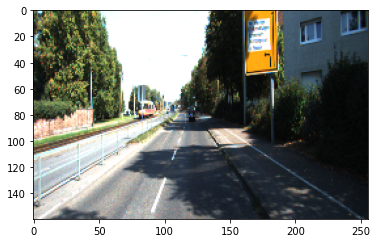

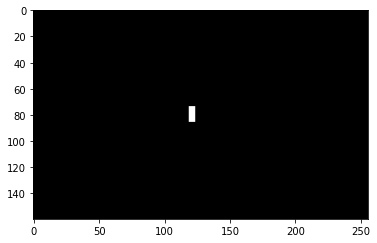

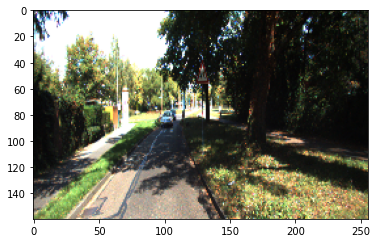

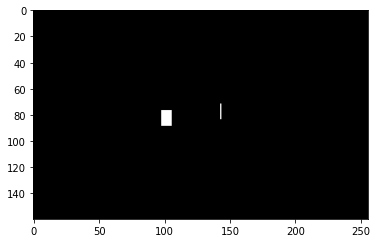

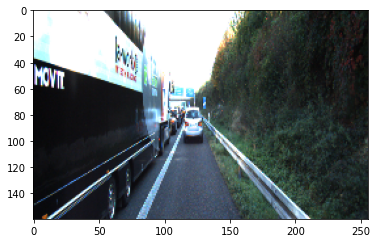

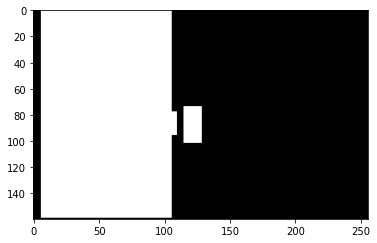

In [173]:
resized_shape = (160, 256)                
train_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)
batch_img, batch_mask = next(train_gen)
for i in range(5):

    im = np.array(255*batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.imshow(im_mask[:,:,0], cmap= 'gray')
    plt.show()

In [161]:
from keras.preprocessing.image import ImageDataGenerator
args_dg = dict(featurewise_center = False, 
               samplewise_center = False, 
               rotation_range = 2, 
               width_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.9, 1.1], 
               horizontal_flip = False, 
               vertical_flip = False,
               fill_mode = 'constant',
               data_format = 'channels_last')

if AUGMENT_BRIGHTNESS:
    args_dg['brightness_range'] = [0.5, 1.5]

image_gen = ImageDataGenerator(**args_dg)

if AUGMENT_BRIGHTNESS:
    args_dg.pop('brightness_range')
mask_gen = ImageDataGenerator(**args_dg)

In [162]:
def make_augment_generator(img_mask_gen, seed=None):
    "Augmenatation if necessary for the training data"
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img_in, mask_in in img_mask_gen:
        seed = np.random.choice(range(9999))
        aug_img_in = image_gen.flow(255*img_in, 
                                 batch_size=img_in.shape[0],
                                 seed = seed, 
                                 shuffle=True)
        aug_mask_in = mask_gen.flow(mask_in, 
                                    batch_size=img_in.shape[0],
                                    seed=seed,
                                    shuffle=True)
        yield next(aug_img_in)/255.0, next(aug_mask_in)

In [163]:
def calc_IOU(y_true, y_pred, smooth=1):
    "IOU calculation function"
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f*y_pred_f)
    
    return (2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

def calc_IOU_loss(y_true, y_pred):
    "Iou loss calculator"
    return -calc_IOU(y_true, y_pred)


def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
def create_unet():
    
    # input_img = layers.Input(batch_img.shape[1:], name = 'RGB_Input')
    input_img = layers.Input((resized_shape[0],resized_shape[1],3), name = 'RGB_Input')
    pp_in_layer = input_img
             
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(pp_in_layer)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)
    
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    
    u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)
    
    d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    if NET_SCALING is not None:
        d = layers.UpSampling2D(NET_SCALING)(d)
    
    seg_model = models.Model(inputs=[input_img], outputs=[d])
    seg_model.summary()
    
    return seg_model


In [164]:

model = create_unet()
model.compile(optimizer=Adam(lr=1e-4),
              loss=calc_IOU_loss, metrics=[calc_IOU])


train_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)
valid_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)


val_img, val_mask = next(valid_gen)  

loss_history = [model.fit(train_gen,
 steps_per_epoch=20,
 epochs=100,
 validation_data=(val_img, val_mask) )]

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 160, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_380 (Conv2D)            (None, 160, 256, 8)  224         ['RGB_Input[0][0]']              
                                                                                                  
 conv2d_381 (Conv2D)            (None, 160, 256, 8)  584         ['conv2d_380[0][0]']             
                                                                                                  
 max_pooling2d_80 (MaxPooling2D  (None, 80, 128, 8)  0           ['conv2d_381[0][0]']      

one
one
Epoch 1/100
one
20/20 [==============================] - 171s 8s/step - loss: -0.1394 - calc_IOU: 0.1394 - val_loss: -0.1394 - val_calc_IOU: 0.1394
Epoch 2/100
one
20/20 [==============================] - 165s 8s/step - loss: -0.1457 - calc_IOU: 0.1457 - val_loss: -0.1535 - val_calc_IOU: 0.1535
Epoch 3/100
one
20/20 [==============================] - 167s 8s/step - loss: -0.1608 - calc_IOU: 0.1608 - val_loss: -0.1719 - val_calc_IOU: 0.1719
Epoch 4/100
one
20/20 [==============================] - 161s 8s/step - loss: -0.1826 - calc_IOU: 0.1826 - val_loss: -0.1921 - val_calc_IOU: 0.1921
Epoch 5/100
one
 9/20 [============>.................] - ETA: 1:27 - loss: -0.1963 - calc_IOU: 0.1963one


20/20 [==============================] - 161s 8s/step - loss: -0.1993 - calc_IOU: 0.1993 - val_loss: -0.2109 - val_calc_IOU: 0.2109
Epoch 6/100
one
20/20 [==============================] - 165s 8s/step - loss: -0.2731 - calc_IOU: 0.2731 - val_loss: -0.3369 - val_calc_IOU: 0.3369
Epoch 7/100
one
20/20 [==============================] - 164s 8s/step - loss: -0.3621 - calc_IOU: 0.3621 - val_loss: -0.4334 - val_calc_IOU: 0.4334
Epoch 8/100
one
20/20 [==============================] - 164s 8s/step - loss: -0.4417 - calc_IOU: 0.4417 - val_loss: -0.4813 - val_calc_IOU: 0.4813
Epoch 9/100
one
18/20 [==========================>...] - ETA: 16s - loss: -0.4785 - calc_IOU: 0.4785one


20/20 [==============================] - 163s 8s/step - loss: -0.4774 - calc_IOU: 0.4774 - val_loss: -0.5083 - val_calc_IOU: 0.5083
Epoch 10/100
one
20/20 [==============================] - 162s 8s/step - loss: -0.5187 - calc_IOU: 0.5187 - val_loss: -0.5445 - val_calc_IOU: 0.5445
Epoch 11/100
one
20/20 [==============================] - 161s 8s/step - loss: -0.5590 - calc_IOU: 0.5590 - val_loss: -0.5850 - val_calc_IOU: 0.5850
Epoch 12/100
one
20/20 [==============================] - 162s 8s/step - loss: -0.5834 - calc_IOU: 0.5834 - val_loss: -0.5985 - val_calc_IOU: 0.5985
Epoch 13/100
one
20/20 [==============================] - 162s 8s/step - loss: -0.5871 - calc_IOU: 0.5871 - val_loss: -0.6284 - val_calc_IOU: 0.6284
Epoch 14/100
one
 7/20 [=========>....................] - ETA: 1:46 - loss: -0.6199 - calc_IOU: 0.6199one


20/20 [==============================] - 165s 8s/step - loss: -0.6307 - calc_IOU: 0.6307 - val_loss: -0.6488 - val_calc_IOU: 0.6488
Epoch 15/100
one
20/20 [==============================] - 162s 8s/step - loss: -0.6576 - calc_IOU: 0.6576 - val_loss: -0.6684 - val_calc_IOU: 0.6684
Epoch 16/100
one
20/20 [==============================] - 163s 8s/step - loss: -0.6569 - calc_IOU: 0.6569 - val_loss: -0.6687 - val_calc_IOU: 0.6687
Epoch 17/100
one
20/20 [==============================] - 165s 8s/step - loss: -0.6848 - calc_IOU: 0.6848 - val_loss: -0.6789 - val_calc_IOU: 0.6789
Epoch 18/100
one
16/20 [=======================>......] - ETA: 32s - loss: -0.6947 - calc_IOU: 0.6947one


20/20 [==============================] - 162s 8s/step - loss: -0.6968 - calc_IOU: 0.6968 - val_loss: -0.7066 - val_calc_IOU: 0.7066
Epoch 19/100
one
20/20 [==============================] - 167s 8s/step - loss: -0.6894 - calc_IOU: 0.6894 - val_loss: -0.7047 - val_calc_IOU: 0.7047
Epoch 20/100
one
20/20 [==============================] - 160s 8s/step - loss: -0.7222 - calc_IOU: 0.7222 - val_loss: -0.7302 - val_calc_IOU: 0.7302
Epoch 21/100
one
20/20 [==============================] - 161s 8s/step - loss: -0.6937 - calc_IOU: 0.6937 - val_loss: -0.7074 - val_calc_IOU: 0.7074
Epoch 22/100
one
20/20 [==============================] - 161s 8s/step - loss: -0.7328 - calc_IOU: 0.7328 - val_loss: -0.7431 - val_calc_IOU: 0.7431
Epoch 23/100
one
 5/20 [======>.......................] - ETA: 2:02 - loss: -0.7389 - calc_IOU: 0.7389one


20/20 [==============================] - 140s 7s/step - loss: -0.7415 - calc_IOU: 0.7415 - val_loss: -0.7535 - val_calc_IOU: 0.7535
Epoch 24/100
one
20/20 [==============================] - 115s 6s/step - loss: -0.7579 - calc_IOU: 0.7579 - val_loss: -0.7277 - val_calc_IOU: 0.7277
Epoch 25/100
one
20/20 [==============================] - 114s 6s/step - loss: -0.7465 - calc_IOU: 0.7465 - val_loss: -0.7556 - val_calc_IOU: 0.7556
Epoch 26/100
one
20/20 [==============================] - 115s 6s/step - loss: -0.7651 - calc_IOU: 0.7651 - val_loss: -0.7800 - val_calc_IOU: 0.7800
Epoch 27/100
one
14/20 [====================>.........] - ETA: 36s - loss: -0.7847 - calc_IOU: 0.7847one


20/20 [==============================] - 125s 6s/step - loss: -0.7859 - calc_IOU: 0.7859 - val_loss: -0.7917 - val_calc_IOU: 0.7917
Epoch 28/100
one
20/20 [==============================] - 117s 6s/step - loss: -0.7829 - calc_IOU: 0.7829 - val_loss: -0.7970 - val_calc_IOU: 0.7970
Epoch 29/100
one
20/20 [==============================] - 114s 6s/step - loss: -0.7925 - calc_IOU: 0.7925 - val_loss: -0.7693 - val_calc_IOU: 0.7693
Epoch 30/100
one
20/20 [==============================] - 120s 6s/step - loss: -0.7924 - calc_IOU: 0.7924 - val_loss: -0.7845 - val_calc_IOU: 0.7845
Epoch 31/100
one
20/20 [==============================] - 118s 6s/step - loss: -0.7975 - calc_IOU: 0.7975 - val_loss: -0.8027 - val_calc_IOU: 0.8027
Epoch 32/100
one
 3/20 [===>..........................] - ETA: 1:46 - loss: -0.8026 - calc_IOU: 0.8026one


20/20 [==============================] - 120s 6s/step - loss: -0.8032 - calc_IOU: 0.8032 - val_loss: -0.7253 - val_calc_IOU: 0.7253
Epoch 33/100
one
20/20 [==============================] - 123s 6s/step - loss: -0.7562 - calc_IOU: 0.7562 - val_loss: -0.7239 - val_calc_IOU: 0.7239
Epoch 34/100
one
20/20 [==============================] - 118s 6s/step - loss: -0.7829 - calc_IOU: 0.7829 - val_loss: -0.8006 - val_calc_IOU: 0.8006
Epoch 35/100
one
20/20 [==============================] - 117s 6s/step - loss: -0.8109 - calc_IOU: 0.8109 - val_loss: -0.8195 - val_calc_IOU: 0.8195
Epoch 36/100
one
12/20 [=================>............] - ETA: 47s - loss: -0.8190 - calc_IOU: 0.8190one


20/20 [==============================] - 118s 6s/step - loss: -0.8189 - calc_IOU: 0.8189 - val_loss: -0.8277 - val_calc_IOU: 0.8277
Epoch 37/100
one
20/20 [==============================] - 118s 6s/step - loss: -0.8210 - calc_IOU: 0.8210 - val_loss: -0.8160 - val_calc_IOU: 0.8160
Epoch 38/100
one
20/20 [==============================] - 119s 6s/step - loss: -0.8112 - calc_IOU: 0.8112 - val_loss: -0.8232 - val_calc_IOU: 0.8232
Epoch 39/100
one
20/20 [==============================] - 124s 6s/step - loss: -0.8225 - calc_IOU: 0.8225 - val_loss: -0.8282 - val_calc_IOU: 0.8282
Epoch 40/100
one
20/20 [==============================] - 125s 6s/step - loss: -0.8344 - calc_IOU: 0.8344 - val_loss: -0.8434 - val_calc_IOU: 0.8434
Epoch 41/100
one
 1/20 [>.............................] - ETA: 1:49 - loss: -0.8383 - calc_IOU: 0.8383one


20/20 [==============================] - 119s 6s/step - loss: -0.8399 - calc_IOU: 0.8399 - val_loss: -0.8496 - val_calc_IOU: 0.8496
Epoch 42/100
one
20/20 [==============================] - 120s 6s/step - loss: -0.8022 - calc_IOU: 0.8022 - val_loss: -0.8002 - val_calc_IOU: 0.8002
Epoch 43/100
one
20/20 [==============================] - 123s 6s/step - loss: -0.8290 - calc_IOU: 0.8290 - val_loss: -0.8319 - val_calc_IOU: 0.8319
Epoch 44/100
one
20/20 [==============================] - 118s 6s/step - loss: -0.8310 - calc_IOU: 0.8310 - val_loss: -0.8534 - val_calc_IOU: 0.8534
Epoch 45/100
one
10/20 [==============>...............] - ETA: 59s - loss: -0.8427 - calc_IOU: 0.8427 one


20/20 [==============================] - 122s 6s/step - loss: -0.8447 - calc_IOU: 0.8447 - val_loss: -0.8560 - val_calc_IOU: 0.8560
Epoch 46/100
one
20/20 [==============================] - 122s 6s/step - loss: -0.8531 - calc_IOU: 0.8531 - val_loss: -0.8600 - val_calc_IOU: 0.8600
Epoch 47/100
one
20/20 [==============================] - 120s 6s/step - loss: -0.8529 - calc_IOU: 0.8529 - val_loss: -0.8636 - val_calc_IOU: 0.8636
Epoch 48/100
one
20/20 [==============================] - 124s 6s/step - loss: -0.8443 - calc_IOU: 0.8443 - val_loss: -0.8641 - val_calc_IOU: 0.8641
Epoch 49/100
one
19/20 [===========================>..] - ETA: 5s - loss: -0.8468 - calc_IOU: 0.8468 one


20/20 [==============================] - 121s 6s/step - loss: -0.8468 - calc_IOU: 0.8468 - val_loss: -0.8577 - val_calc_IOU: 0.8577
Epoch 50/100
one
20/20 [==============================] - 125s 6s/step - loss: -0.8218 - calc_IOU: 0.8218 - val_loss: -0.8073 - val_calc_IOU: 0.8073
Epoch 51/100
one
20/20 [==============================] - 124s 6s/step - loss: -0.8443 - calc_IOU: 0.8443 - val_loss: -0.8497 - val_calc_IOU: 0.8497
Epoch 52/100
one
20/20 [==============================] - 127s 6s/step - loss: -0.8525 - calc_IOU: 0.8525 - val_loss: -0.8690 - val_calc_IOU: 0.8690
Epoch 53/100
one
20/20 [==============================] - 129s 6s/step - loss: -0.8659 - calc_IOU: 0.8659 - val_loss: -0.8727 - val_calc_IOU: 0.8727
Epoch 54/100
one
 8/20 [===========>..................] - ETA: 1:16 - loss: -0.8652 - calc_IOU: 0.8652one


20/20 [==============================] - 125s 6s/step - loss: -0.8653 - calc_IOU: 0.8653 - val_loss: -0.8698 - val_calc_IOU: 0.8698
Epoch 55/100
one
20/20 [==============================] - 122s 6s/step - loss: -0.8663 - calc_IOU: 0.8663 - val_loss: -0.8711 - val_calc_IOU: 0.8711
Epoch 56/100
one
20/20 [==============================] - 127s 6s/step - loss: -0.8643 - calc_IOU: 0.8643 - val_loss: -0.8774 - val_calc_IOU: 0.8774
Epoch 57/100
one
20/20 [==============================] - 119s 6s/step - loss: -0.8513 - calc_IOU: 0.8513 - val_loss: -0.8444 - val_calc_IOU: 0.8444
Epoch 58/100
one
17/20 [========================>.....] - ETA: 17s - loss: -0.8639 - calc_IOU: 0.8639one


20/20 [==============================] - 120s 6s/step - loss: -0.8650 - calc_IOU: 0.8650 - val_loss: -0.8781 - val_calc_IOU: 0.8781
Epoch 59/100
one
20/20 [==============================] - 121s 6s/step - loss: -0.8737 - calc_IOU: 0.8737 - val_loss: -0.8809 - val_calc_IOU: 0.8809
Epoch 60/100
one
20/20 [==============================] - 121s 6s/step - loss: -0.8590 - calc_IOU: 0.8590 - val_loss: -0.8801 - val_calc_IOU: 0.8801
Epoch 61/100
one
20/20 [==============================] - 120s 6s/step - loss: -0.8691 - calc_IOU: 0.8691 - val_loss: -0.8745 - val_calc_IOU: 0.8745
Epoch 62/100
one
20/20 [==============================] - 121s 6s/step - loss: -0.8781 - calc_IOU: 0.8781 - val_loss: -0.8777 - val_calc_IOU: 0.8777
Epoch 63/100
one
 6/20 [========>.....................] - ETA: 1:21 - loss: -0.8755 - calc_IOU: 0.8755one


20/20 [==============================] - 120s 6s/step - loss: -0.8783 - calc_IOU: 0.8783 - val_loss: -0.8774 - val_calc_IOU: 0.8774
Epoch 64/100
one
20/20 [==============================] - 121s 6s/step - loss: -0.8673 - calc_IOU: 0.8673 - val_loss: -0.8289 - val_calc_IOU: 0.8289
Epoch 65/100
one
20/20 [==============================] - 119s 6s/step - loss: -0.8680 - calc_IOU: 0.8680 - val_loss: -0.8871 - val_calc_IOU: 0.8871
Epoch 66/100
one
20/20 [==============================] - 121s 6s/step - loss: -0.8785 - calc_IOU: 0.8785 - val_loss: -0.8519 - val_calc_IOU: 0.8519
Epoch 67/100
one
15/20 [=====================>........] - ETA: 29s - loss: -0.8771 - calc_IOU: 0.8771one


20/20 [==============================] - 122s 6s/step - loss: -0.8776 - calc_IOU: 0.8776 - val_loss: -0.8815 - val_calc_IOU: 0.8815
Epoch 68/100
one
20/20 [==============================] - 119s 6s/step - loss: -0.8863 - calc_IOU: 0.8863 - val_loss: -0.8845 - val_calc_IOU: 0.8845
Epoch 69/100
one
20/20 [==============================] - 123s 6s/step - loss: -0.8850 - calc_IOU: 0.8850 - val_loss: -0.8817 - val_calc_IOU: 0.8817
Epoch 70/100
one
20/20 [==============================] - 125s 6s/step - loss: -0.8763 - calc_IOU: 0.8763 - val_loss: -0.8819 - val_calc_IOU: 0.8819
Epoch 71/100
one
20/20 [==============================] - 119s 6s/step - loss: -0.8907 - calc_IOU: 0.8907 - val_loss: -0.8983 - val_calc_IOU: 0.8983
Epoch 72/100
one
 4/20 [=====>........................] - ETA: 1:30 - loss: -0.8972 - calc_IOU: 0.8972one


20/20 [==============================] - 123s 6s/step - loss: -0.8952 - calc_IOU: 0.8952 - val_loss: -0.9015 - val_calc_IOU: 0.9015
Epoch 73/100
one
20/20 [==============================] - 121s 6s/step - loss: -0.8934 - calc_IOU: 0.8934 - val_loss: -0.8958 - val_calc_IOU: 0.8958
Epoch 74/100
one
20/20 [==============================] - 122s 6s/step - loss: -0.8967 - calc_IOU: 0.8967 - val_loss: -0.8901 - val_calc_IOU: 0.8901
Epoch 75/100
one
20/20 [==============================] - 121s 6s/step - loss: -0.8960 - calc_IOU: 0.8960 - val_loss: -0.8882 - val_calc_IOU: 0.8882
Epoch 76/100
one
13/20 [==================>...........] - ETA: 42s - loss: -0.8977 - calc_IOU: 0.8977one


20/20 [==============================] - 120s 6s/step - loss: -0.8974 - calc_IOU: 0.8974 - val_loss: -0.9070 - val_calc_IOU: 0.9070
Epoch 77/100
one
20/20 [==============================] - 128s 6s/step - loss: -0.8967 - calc_IOU: 0.8967 - val_loss: -0.8958 - val_calc_IOU: 0.8958
Epoch 78/100
one
20/20 [==============================] - 126s 6s/step - loss: -0.8987 - calc_IOU: 0.8987 - val_loss: -0.9073 - val_calc_IOU: 0.9073
Epoch 79/100
one
20/20 [==============================] - 122s 6s/step - loss: -0.8946 - calc_IOU: 0.8946 - val_loss: -0.8936 - val_calc_IOU: 0.8936
Epoch 80/100
one
20/20 [==============================] - 116s 6s/step - loss: -0.8790 - calc_IOU: 0.8790 - val_loss: -0.8649 - val_calc_IOU: 0.8649
Epoch 81/100
one
 2/20 [==>...........................] - ETA: 1:44 - loss: -0.8851 - calc_IOU: 0.8851one


20/20 [==============================] - 118s 6s/step - loss: -0.9016 - calc_IOU: 0.9016 - val_loss: -0.9099 - val_calc_IOU: 0.9099
Epoch 82/100
one
20/20 [==============================] - 120s 6s/step - loss: -0.9081 - calc_IOU: 0.9081 - val_loss: -0.9135 - val_calc_IOU: 0.9135
Epoch 83/100
one
20/20 [==============================] - 119s 6s/step - loss: -0.9000 - calc_IOU: 0.9000 - val_loss: -0.9116 - val_calc_IOU: 0.9116
Epoch 84/100
one
20/20 [==============================] - 116s 6s/step - loss: -0.9002 - calc_IOU: 0.9002 - val_loss: -0.8946 - val_calc_IOU: 0.8946
Epoch 85/100
one
11/20 [===============>..............] - ETA: 52s - loss: -0.9015 - calc_IOU: 0.9015one


20/20 [==============================] - 118s 6s/step - loss: -0.9069 - calc_IOU: 0.9069 - val_loss: -0.9156 - val_calc_IOU: 0.9156
Epoch 86/100
one
20/20 [==============================] - 116s 6s/step - loss: -0.9129 - calc_IOU: 0.9129 - val_loss: -0.9049 - val_calc_IOU: 0.9049
Epoch 87/100
one
20/20 [==============================] - 116s 6s/step - loss: -0.9103 - calc_IOU: 0.9103 - val_loss: -0.9166 - val_calc_IOU: 0.9166
Epoch 88/100
one
20/20 [==============================] - 116s 6s/step - loss: -0.9149 - calc_IOU: 0.9149 - val_loss: -0.9156 - val_calc_IOU: 0.9156
Epoch 89/100
one
20/20 [==============================] - 119s 6s/step - loss: -0.9109 - calc_IOU: 0.9109 - val_loss: -0.9096 - val_calc_IOU: 0.9096
Epoch 90/100
one


20/20 [==============================] - 116s 6s/step - loss: -0.9159 - calc_IOU: 0.9159 - val_loss: -0.9220 - val_calc_IOU: 0.9220
Epoch 91/100
one
20/20 [==============================] - 116s 6s/step - loss: -0.9180 - calc_IOU: 0.9180 - val_loss: -0.9187 - val_calc_IOU: 0.9187
Epoch 92/100
one
20/20 [==============================] - 116s 6s/step - loss: -0.9137 - calc_IOU: 0.9137 - val_loss: -0.9129 - val_calc_IOU: 0.9129
Epoch 93/100
one
20/20 [==============================] - 121s 6s/step - loss: -0.9094 - calc_IOU: 0.9094 - val_loss: -0.9194 - val_calc_IOU: 0.9194
Epoch 94/100
one
 9/20 [============>.................] - ETA: 1:03 - loss: -0.9187 - calc_IOU: 0.9187one


20/20 [==============================] - 116s 6s/step - loss: -0.9113 - calc_IOU: 0.9113 - val_loss: -0.9099 - val_calc_IOU: 0.9099
Epoch 95/100
one
20/20 [==============================] - 118s 6s/step - loss: -0.9182 - calc_IOU: 0.9182 - val_loss: -0.9236 - val_calc_IOU: 0.9236
Epoch 96/100
one
20/20 [==============================] - 115s 6s/step - loss: -0.9171 - calc_IOU: 0.9171 - val_loss: -0.9242 - val_calc_IOU: 0.9242
Epoch 97/100
one
20/20 [==============================] - 117s 6s/step - loss: -0.9211 - calc_IOU: 0.9211 - val_loss: -0.9064 - val_calc_IOU: 0.9064
Epoch 98/100
one
18/20 [==========================>...] - ETA: 11s - loss: -0.9212 - calc_IOU: 0.9212one


20/20 [==============================] - 117s 6s/step - loss: -0.9218 - calc_IOU: 0.9218 - val_loss: -0.9197 - val_calc_IOU: 0.9197
Epoch 99/100
one
20/20 [==============================] - 119s 6s/step - loss: -0.9217 - calc_IOU: 0.9217 - val_loss: -0.9158 - val_calc_IOU: 0.9158
Epoch 100/100
one
20/20 [==============================] - 119s 6s/step - loss: -0.9236 - calc_IOU: 0.9236 - val_loss: -0.9270 - val_calc_IOU: 0.9270


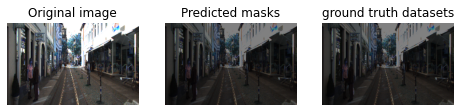

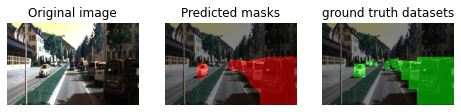

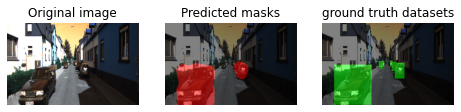

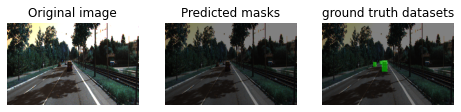

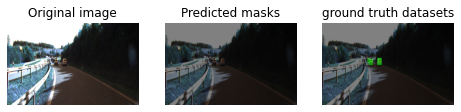

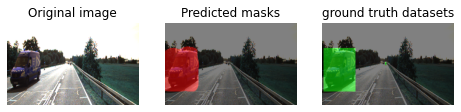

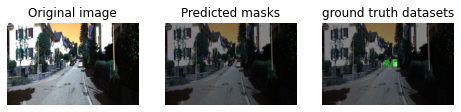

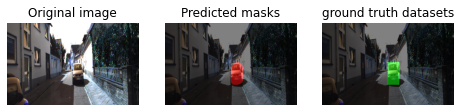

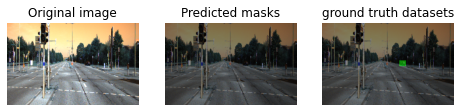

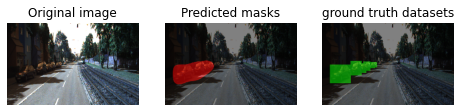

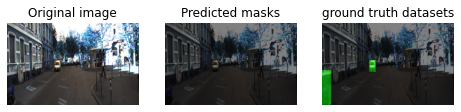

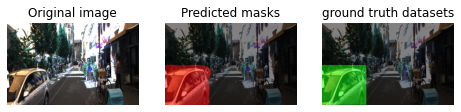

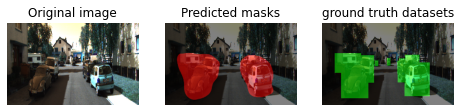

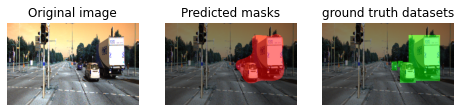

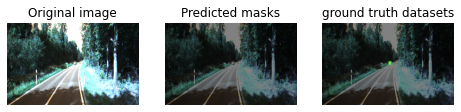

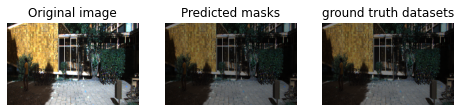

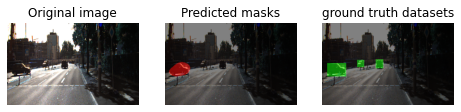

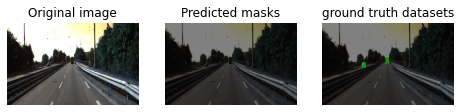

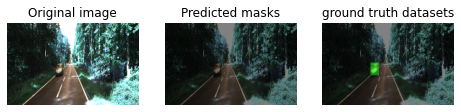

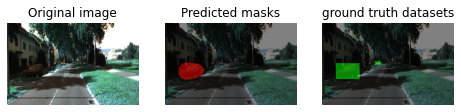

In [165]:
pred_all= model.predict(val_img)
np.shape(pred_all)

for i in range(20):

    im = np.array(255*val_img[i],dtype=np.uint8)
    im_mask = np.array(255*val_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    im_pred1 = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred1 = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    temp1 = rgb_mask_pred[:,:,1:3]
    temp2 = rgb_mask_pred[:,:,1:2]
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:3]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted masks')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('ground truth datasets')
    plt.axis('off')
    plt.show()    